# Linear Model Selection and Regularisation

In [142]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, statsmodels.api as sm
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import BaseEstimator
from functools import partial


**1. Forward and backward stepwise regression with simulated data**

*(a) Create a random number generator and use its `normal()` method to generate a predictor X of length $n = 100$, as well as a noise vector $\epsilon$ of length $n = 100$.*

In [46]:
np.random.seed(42)
X = np.random.randn(100)
e = np.random.randn(100)

X.shape, e.shape

((100,), (100,))

*(b) Generate a response vector $Y$ of length $n = 100$ according to the model*

$$
Y = \beta_{0} +\beta_{1}X + \beta_{2}X^{2} + \beta_{3}X^{3} + \epsilon
$$

Where $\beta_{0} +\beta_{1} + \beta_{2} + \beta_{3}$ are constants of your choice

In [88]:
y = 2 + 7*X - 2*X**2 + 1/2 * X**3 + e

y.shape

(100,)

*(c) Use forward stepwise selection in order to select a model containing the predictors $X,X_{2}, . . . ,X_{10}$. What is the model obtained according to $C_{p}$? Report the coefficients of the model obtained.*

Firstly, $C_{p}$ is not a metric in sklearn or statsmodel, so we will write a function to calculate this. For a fitted least squares model with $d$ predictors, the $C_{p}$ estimate of the test MSE is computed by,

$$
C_{p} = \frac{1}{n}(RSS + 2d\hat{\sigma}^{2})
$$

Where $\hat{\sigma}^{2}$ is an estimate of the variance of the error $\epsilon$ associated with each response measurement.

In [49]:
def nCp(sigma2:float, estimator:BaseEstimator, X:np.ndarray, y:np.ndarray) -> float:
    """
    negative Cp statistic
    """
    n, p = X.shape
    yhat = estimator.predict(X)
    rss = np.sum((y - yhat)**2)
    return -(rss + 2 * p * sigma2)/n

There is also no built in functionality for performing stepwise regression in sklearn. We will write a function to perform forward stepwise selection to select a model.

In [50]:
def forward_stepwise_regression(X:np.ndarray, y:np.ndarray, scoring_func:callable):
    """
    Performs forward stepwise regression based on the scoring function passed.
    Forward stepwise regression starts with the null model and sequentially adds
    predictors, selecting only the best performing model with at each stage.
    Performance is defined by the return value of the scoring_func argument passed to the model.
    Forward stepwise seeks to maximise the scoring function.

    The function returns the an array containing the column indexes of the best predictors
    """
    best_score = -float('inf')
    best_predictors = []
    continue_search = True

    while continue_search:
        predictor_used = None
        for p in range(X.shape[1]):
            if p not in best_predictors:
                X_current = sm.add_constant(X[:, best_predictors + [p]])
                model = sm.OLS(y, X_current).fit()
                score = scoring_func(model, X_current, y)

                if score > best_score:
                    best_score = score
                    predictor_used = p
        
        if predictor_used is None:
            continue_search = False
        else:
            best_predictors.append(predictor_used)

    
    return best_predictors

The parameter $\sigma^{2}$ used to calculate the $C_{p}$ statistic is usually estimated using the full model containing all of the predictors. Lets calculate this and freeze its value in a new partial object

first lets create the full set of predictors

In [51]:
X_full = np.power.outer(X, range(1, 11))
X_full.shape

(100, 10)

Now fit the full model

In [52]:
X_full_wconstant = sm.add_constant(X_full)
full_model = sm.OLS(y, X_full_wconstant).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     796.2
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           1.69e-82
Time:                        14:46:40   Log-Likelihood:                -129.32
No. Observations:                 100   AIC:                             280.6
Df Residuals:                      89   BIC:                             309.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8694      0.196      9.543      0.000       1.480       2.259
x1             6.4471      0.670      9.616      0.000       5.115       7.779
x2            -2.8594      1.475     -1.938      0.056      -5.790       0.072
x3             2.4152      2.666      0.906      0.367      -2.881       7.712
x4             3.0148      2.462      1.224      0.224      -1.877       7.907
x5            -2.0902      3.194     -0.654      0.515      -8.437       4.256
x6            -2.4130      1.578     -1.529      0.130      -5.549       0.723
x7             0.8639      1.390      0.622      0.536      -1.898       3.626
x8             0.7335      0.509      1.441      0.153      -0.278       1.745
x9            -0.1181      0.195     -0.606      0.546      -0.505       0.269
x10           -0.0764      0.068     -1.125      0.264      -0.211       0.059
==============================================================================
Omnibus:                        0.107   Durbin-Watson:                   2.234
Prob(Omnibus):                  0.948   Jarque-Bera (JB):                0.284
Skew:                           0.005   Prob(JB):                        0.867
Kurtosis:                       2.739   Cond. No.                     8.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The scale property of the full model is the estimate $\sigma^{2}$. Now we create this variable and use it to freeze the Cp function and create a partial object 

In [53]:
sigma2 = full_model.scale
print(sigma2)
nCp_frozen = partial(nCp, sigma2)

0.8737538686644177


This partial object can now be used as the scoring function in our forward stepwise regression function

In [54]:
fsr_predictors = forward_stepwise_regression(X_full, y, nCp_frozen)
fsr_predictors

[0, 1, 2]

Forward stepwise regression selected the following predictors $X, X^{2}, X^{3}$ The coefficients are reported below.

In [57]:
selected_predictors_df = pd.DataFrame(data=sm.add_constant(X_full[:, fsr_predictors]), columns=['Const', 'X', 'X2', 'X3'])
fsr_model = sm.OLS(y, selected_predictors_df).fit()
fsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2644.
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           4.17e-92
Time:                        14:46:59   Log-Likelihood:                -133.24
No. Observations:                 100   AIC:                             274.5
Df Residuals:                      96   BIC:                             284.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          1.8479      0.121     15.282      0.000       1.608       2.088
X              6.8643      0.186     36.954      0.000       6.496       7.233
X2            -1.7931      0.102    -17.534      0.000      -1.996      -1.590
X3             0.5284      0.071      7.396      0.000       0.387       0.670
==============================================================================
Omnibus:                        1.875   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.802
Skew:                           0.242   Prob(JB):                        0.406
Kurtosis:                       2.555   Cond. No.                         6.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*(d) Now do the same but use backward stepwise regression*

Again there is no implementation of backward stepwise regression so we will write a function to handle this.

In [58]:
def backward_stepwise_regression(X:np.ndarray, y:np.ndarray, scoring_func:callable):
    """
    Performs backward stepwise regression based on the scoring function passed.
    Backward stepwise regression starts with the full model and sequentially removes
    predictors, selecting only the best performing model with at each stage.
    Performance is defined by the return value of the scoring_func argument passed to the model.
    Backward stepwise seeks to maximise the scoring function.

    The function returns the an array containing the column indexes of the best predictors
    """
    full_model = sm.OLS(y, sm.add_constant(X)).fit()
    best_score = scoring_func(full_model, sm.add_constant(X), y)
    best_predictors = [i for i in range(X.shape[1])]
    continue_search = True
    
    while continue_search:
        predictor_removed = None
        for p in range(X.shape[1]):
            if p in best_predictors:
                X_currrent = sm.add_constant(X[:, [i for i in best_predictors if i != p]])
                model = sm.OLS(y, X_currrent).fit()
                score = scoring_func(model, X_currrent, y)

                if score > best_score:
                    best_score = score
                    predictor_removed = p
        
        if predictor_removed is None:
            continue_search = False

        else:
            best_predictors.remove(predictor_removed)
    
    return best_predictors



            
    

We can run backward stepwise regression

In [59]:
bsr_predictors = backward_stepwise_regression(X_full, y, nCp_frozen)
bsr_predictors

[0, 1, 2, 5, 7, 9]

In [63]:
bsr_selected_predictors = pd.DataFrame(data=sm.add_constant(X_full[:, bsr_predictors]), columns=['Const', 'X', 'X2', 'X3', 'X6', 'X8', 'X10'])
bsr_model = sm.OLS(y, bsr_selected_predictors).fit()
bsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1353.
Date:                Sat, 03 Aug 2024   Prob (F-statistic):           3.66e-88
Time:                        14:47:42   Log-Likelihood:                -130.52
No. Observations:                 100   AIC:                             275.0
Df Residuals:                      93   BIC:                             293.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          1.7293      0.151     11.460      0.000       1.430       2.029
X              6.9520      0.230     30.277      0.000       6.496       7.408
X2            -1.2199      0.409     -2.983      0.004      -2.032      -0.408
X3             0.4999      0.112      4.445      0.000       0.277       0.723
X6            -0.3815      0.223     -1.707      0.091      -0.825       0.062
X8             0.1438      0.082      1.762      0.081      -0.018       0.306
X10           -0.0132      0.007     -1.802      0.075      -0.028       0.001
==============================================================================
Omnibus:                        0.562   Durbin-Watson:                   2.177
Prob(Omnibus):                  0.755   Jarque-Bera (JB):                0.707
Skew:                           0.118   Prob(JB):                        0.702
Kurtosis:                       2.663   Cond. No.                     7.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*(e) Now fit a lasso model agaisnt the simulated data. Use cross-validation to select the optimal $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the coefficient estimates and discuss the results obtained.*

We can fit a lasso model with cross validation using the `sklearn.ElasticNetCV()` function. Furthermore, it is important to standardise the predictors when fitting a lasso model. To scale the predictors we can use the `StandardScaler()` object provided by sklearn. Finally, we can package up feature preprocessing and model fitting into a single object by using sklearns `Pipeline()` object.

In [64]:
scaler = StandardScaler(with_mean=True, with_std=True)
lambdas = 10**np.linspace(8, -2, 100) / y.std()
lasso_cv = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=5)
pipeline = Pipeline(steps=[('scaler', scaler), ('lasso', lasso_cv)])
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(alphas=array([1.19231684e+07, 9.44890702e+06, 7.48809722e+06, 5.93418899e+06,
       4.70274329e+06, 3.72684363e+06, 2.95345984e+06, 2.34056642e+06,
       1.85485886e+06, 1.46994392e+06, 1.16490542e+06, 9.23167625e+05,
       7.31594555e+05, 5.79776173e+05, 4.59462702e+05, 3.64116334e+05,
       2.88555968e+05, 2.28675670e+05,...
       2.50971265e-01, 1.98890436e-01, 1.57617269e-01, 1.24908990e-01,
       9.89882384e-02, 7.84464861e-02, 6.21674987e-02, 4.92666795e-02,
       3.90430010e-02, 3.09409106e-02, 2.45201425e-02, 1.94317936e-02,
       1.53993641e-02, 1.22037327e-02, 9.67124946e-03, 7.66429980e-03,
       6.07382652e-03, 4.81340365e-03, 3.81454007e-03, 3.02295777e-03,
       2.39564234e-03, 1.89850558e-03, 1.50453321e-03, 1.19231684e-03]),
                              cv=5, l1_ratio=1))])

In [65]:
pipeline.fit(sm.add_constant(X_full), y)
tuned_lasso = pipeline.named_steps['lasso']


c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.146363661309735, tolerance: 0.5682285842837427
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3784263564984656, tolerance: 0.6041672641659223
  model = cd_fast.enet_coordinate_descent_gram(


We plot the cv error as a function of the $-log(\lambda)$ which has shrinkage decreasing from left to right. We can see the optimal value of $\lambda$ plotted on the chart. Also note that for a large range of $\lambda$ values the same model is fit - this is the straight horizontal line on the chart. Here the shrinkage parameter is too large which results in the null model always being fit.

Text(0.5, 0, '$-log(\\lambda)$')

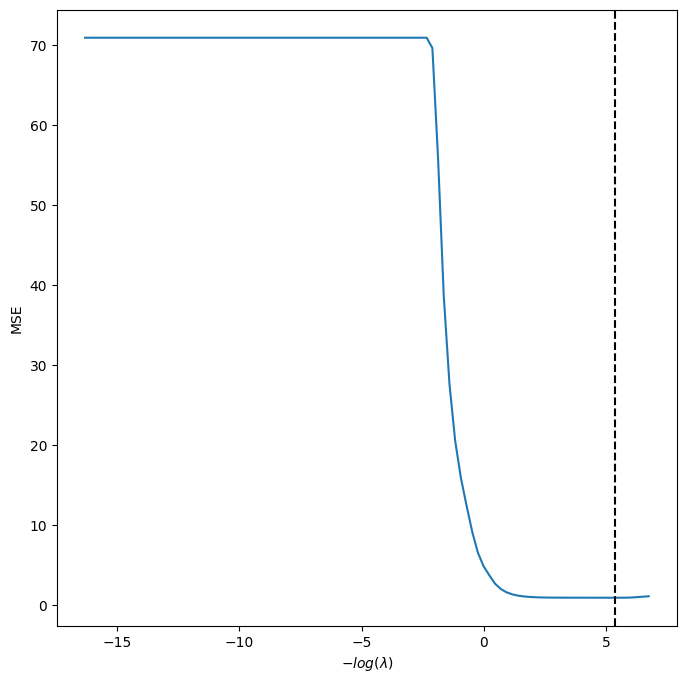

In [66]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylabel('MSE')
ax.set_xlabel(r'$-log(\lambda)$')

Lets have a look at the coefficient estimates of the lasso model

In [67]:
lasso_coefs = pd.Series(data=tuned_lasso.coef_.T, index=['Const', 'X', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
lasso_coefs

Const    0.000000
X        6.352222
X2      -2.021187
X3       1.154284
X4      -0.000000
X5      -0.000000
X6      -0.000000
X7      -0.000000
X8      -0.000000
X9       0.000000
X10     -0.227000
dtype: float64

We can see that many of the coefficient estimates have been shrunk to 0. Furthermore, the lasso has correctly identified all of the predictors that have a relationship with response (except the intercept), it has incorrectly identified $X^{10}$ as being a significant predictor 

*(f) Now generate a response vector $Y$ according to the model*

$$
Y = \beta_{0} + \beta_{7}X^{7} + \epsilon
$$

Perform forward stepwise selection and the lasso. Discuss the results obtained

In [91]:
y = 5 + 2*X**7 + e

y.shape

(100,)

In [92]:
fsr_predictors = forward_stepwise_regression(X_full, y, nCp_frozen)
fsr_predictors

[6, 1, 8]

In [93]:
fsr_selected_predictors = pd.DataFrame(data=sm.add_constant(X_full[:, fsr_predictors]), columns=['Const', 'X7', 'X2', 'X9'])
fsr_model = sm.OLS(y, fsr_selected_predictors).fit()
fsr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.178e+06
Date:                Sat, 03 Aug 2024   Prob (F-statistic):          5.44e-219
Time:                        14:53:50   Log-Likelihood:                -131.90
No. Observations:                 100   AIC:                             271.8
Df Residuals:                      96   BIC:                             282.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Const          4.8434      0.119     40.557      0.000       4.606       5.080
X7             1.9859      0.009    214.680      0.000       1.968       2.004
X2             0.2084      0.104      2.013      0.047       0.003       0.414
X9             0.0022      0.001      1.647      0.103      -0.000       0.005
==============================================================================
Omnibus:                        1.722   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.454
Skew:                           0.137   Prob(JB):                        0.483
Kurtosis:                       2.476   Cond. No.                         917.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
pipeline.fit(sm.add_constant(X_full), y)
tuned_lasso = pipeline.named_steps['lasso']

In [95]:
lasso_coefs = pd.Series(data=tuned_lasso.coef_.T, index=['Const', 'X', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10'])
lasso_coefs

Const     0.000000
X         1.924126
X2       -1.606710
X3      -18.010308
X4        7.621669
X5       67.629525
X6       -8.550642
X7       68.858265
X8       -2.852450
X9       47.270143
X10      -0.371208
dtype: float64

**2.In this exercise, we will predict the number of applications received using the other variables in the College data set.**

In [98]:
college = pd.read_csv(r'C:\Users\caine\OneDrive\Documents\statistical_learning_problems\0 datasets\College.csv')
college.head()

,Unnamed: 0,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [100]:
college.rename(columns={'Unnamed: 0':'College'}, inplace=True)

In [103]:
college.isnull().sum(axis=0)

College        0
Private        0
Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Room.Board     0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

In [131]:
college.describe()

,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Const
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.00000,777.0
mean,3001.638353,2018.804376,779.972973,27.558559,55.796654,3699.907336,855.298584,10440.669241,4357.526384,549.380952,1340.642214,72.660232,79.702703,14.089704,22.743887,9660.171171,65.46332,1.0
std,3870.201484,2451.113971,929.176190,17.640364,19.804778,4850.420531,1522.431887,4023.016484,1096.696416,165.105360,677.071454,16.328155,14.722359,3.958349,12.391801,5221.768440,17.17771,0.0
min,81.000000,72.000000,35.000000,1.000000,9.000000,139.000000,1.000000,2340.000000,1780.000000,96.000000,250.000000,8.000000,24.000000,2.500000,0.000000,3186.000000,10.00000,1.0
25%,776.000000,604.000000,242.000000,15.000000,41.000000,992.000000,95.000000,7320.000000,3597.000000,470.000000,850.000000,62.000000,71.000000,11.500000,13.000000,6751.000000,53.00000,1.0
50%,1558.000000,1110.000000,434.000000,23.000000,54.000000,1707.000000,353.000000,9990.000000,4200.000000,500.000000,1200.000000,75.000000,82.000000,13.600000,21.000000,8377.000000,65.00000,1.0
75%,3624.000000,2424.000000,902.000000,35.000000,69.000000,4005.000000,967.000000,12925.000000,5050.000000,600.000000,1700.000000,85.000000,92.000000,16.500000,31.000000,10830.000000,78.00000,1.0
max,48094.000000,26330.000000,6392.000000,96.000000,100.000000,31643.000000,21836.000000,21700.000000,8124.000000,2340.000000,6800.000000,103.000000,100.000000,39.800000,64.000000,56233.000000,118.00000,1.0


In [112]:
college['Const'] = 1

In [209]:
college['Private'] = (college['Private'] == 'Yes').astype(float)

*(a) Split the data set into a training set and a test set.*

In [221]:
train_x, test_x, train_y, test_y = skm.train_test_split(college.drop(['Apps', 'College'], axis=1), college['Apps'], random_state=42)

In [222]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((582, 18), (195, 18), (582,), (195,))

*(b) Fit a linear model using least squares on the training set, and report the test error obtained*

In [223]:
apps_ols_model = sm.OLS(train_y, train_x).fit()
apps_ols_model.summary()

c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\statsmodels\regression\linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Apps   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     571.1
Date:                Sat, 03 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:45:56   Log-Likelihood:                -4817.7
No. Observations:                 582   AIC:                             9669.
Df Residuals:                     565   BIC:                             9744.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Private              0          0        nan        nan           0           0
Accept          1.7048      0.044     38.868      0.000       1.619       1.791
Enroll         -1.2310      0.200     -6.149      0.000      -1.624      -0.838
Top10perc      42.1534      5.872      7.179      0.000      30.620      53.686
Top25perc      -9.3041      4.778     -1.947      0.052     -18.690       0.082
F.Undergrad     0.0868      0.035      2.463      0.014       0.018       0.156
P.Undergrad    -0.0075      0.043     -0.175      0.861      -0.092       0.077
Outstate       -0.1064      0.019     -5.633      0.000      -0.143      -0.069
Room.Board      0.1633      0.052      3.124      0.002       0.061       0.266
Books           0.0873      0.264      0.330      0.742      -0.432       0.607
Personal        0.0638      0.068      0.932      0.352      -0.071       0.198
PhD            -8.6828      5.153     -1.685      0.093     -18.805       1.439
Terminal        1.8037      5.513      0.327      0.744      -9.024      12.631
S.F.Ratio      22.5427     13.418      1.680      0.094      -3.813      48.898
perc.alumni    -0.6193      4.463     -0.139      0.890      -9.385       8.146
Expend          0.0493      0.013      3.922      0.000       0.025       0.074
Grad.Rate       6.1704      3.055      2.020      0.044       0.170      12.171
Const        -896.4642    413.683     -2.167      0.031   -1709.008     -83.920
==============================================================================
Omnibus:                      367.704   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9191.759
Skew:                           2.333   Prob(JB):                         0.00
Kurtosis:                      21.901   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [224]:
apps_ols_preds = apps_ols_model.predict(test_x)
apps_ols_mse = mean_squared_error(test_y, apps_ols_preds)
apps_ols_mse

1795321.657095538

*(c) Fit a ridge regression model on the training set, with $\lambda$ chosen by cross-validation. Report the test error obtained.*

In [225]:
lambdas = 10**np.linspace(8, -2, 1000) / college['Apps'].std()
scaler = StandardScaler(with_mean=True, with_std=True)
ridge = skl.ElasticNetCV(l1_ratio=0, alphas=lambdas)
apps_ridge_pipeline = Pipeline([('scaler', scaler), ('ridge', ridge)])

In [226]:
apps_ridge_pipeline.fit(train_x, train_y)

c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3729673301.1323414, tolerance: 746024.0927655915
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\caine\OneDrive\Documents\statistical_learning_problems\sl_env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.58384481e+04, 2.52497112e+04, 2.46743889e+04, 2.41121754e+04,
       2.35627722e+04, 2.30258873e+04, 2.25012355e+04, 2.19885380e+04,
       2.14875225e+04, 2.09979228e+04, 2.05194788e+04, 2.00519362e+04,
       1.95950468e+04, 1.91485677e+04, 1.87122618e+04, 1.82858972e+04,
       1.78692475e+04, 1.74620913e+04,...
       4.39032484e-06, 4.29028996e-06, 4.19253440e-06, 4.09700624e-06,
       4.00365471e-06, 3.91243022e-06, 3.82328431e-06, 3.73616962e-06,
       3.65103987e-06, 3.56784982e-06, 3.48655528e-06, 3.40711306e-06,
       3.32948095e-06, 3.25361772e-06, 3.17948306e-06, 3.10703757e-06,
       3.03624278e-06, 2.96706107e-06, 2.89945568e-06, 2.83339071e-06,
       2.76883104e-06, 2.70574238e-06, 2.64409122e-06, 2.58384481e-06]),
                              l1_ratio=0))])

In [227]:
apps_ridge_preds = apps_ridge_pipeline.predict(test_x)
apps_ridge_mse = mean_squared_error(test_y, apps_ridge_preds)
apps_ridge_mse

1795287.1239748332

*(d) Fit a lasso model on the training set, with $\lambda$ chosen by cross validation. Report the test error along with the coefficients*

In [228]:
lasso = skl.ElasticNetCV(l1_ratio=1, alphas=lambdas)
apps_lasso_pipeline = Pipeline([('scaler', scaler), ('lasso', lasso)])

In [232]:
apps_lasso_pipeline.fit(train_x, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(alphas=array([2.58384481e+04, 2.52497112e+04, 2.46743889e+04, 2.41121754e+04,
       2.35627722e+04, 2.30258873e+04, 2.25012355e+04, 2.19885380e+04,
       2.14875225e+04, 2.09979228e+04, 2.05194788e+04, 2.00519362e+04,
       1.95950468e+04, 1.91485677e+04, 1.87122618e+04, 1.82858972e+04,
       1.78692475e+04, 1.74620913e+04,...
       4.39032484e-06, 4.29028996e-06, 4.19253440e-06, 4.09700624e-06,
       4.00365471e-06, 3.91243022e-06, 3.82328431e-06, 3.73616962e-06,
       3.65103987e-06, 3.56784982e-06, 3.48655528e-06, 3.40711306e-06,
       3.32948095e-06, 3.25361772e-06, 3.17948306e-06, 3.10703757e-06,
       3.03624278e-06, 2.96706107e-06, 2.89945568e-06, 2.83339071e-06,
       2.76883104e-06, 2.70574238e-06, 2.64409122e-06, 2.58384481e-06]),
                              l1_ratio=1))])

In [233]:
apps_lasso_preds = apps_lasso_pipeline.predict(test_x)
apps_lasso_mse = mean_squared_error(test_y, apps_lasso_preds)
apps_lasso_mse

1795321.6443468027

In [234]:
apps_lasso_pipeline.named_steps['lasso'].coef_.T

array([    0.        ,  4284.7942654 , -1075.48014397,   727.21217316,
        -180.34039481,   392.90402783,    -9.66597546,  -419.88216841,
         179.27487959,    14.01623889,    42.57810788,  -141.67889938,
          27.0316322 ,    90.01093289,    -7.44076409,   260.08269008,
         107.38732086,     0.        ])

*(e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.*

To fit a PCR model we must first find the optimal number of principle components. We can do this using `GridSearchCV` class provided by sklearn.

In [238]:
#sklearns linear regression fits a const by default
train_x, test_x, train_y, test_y = skm.train_test_split(college.drop(['Apps', 'College', 'Const'], axis=1), college['Apps'], random_state=42)

#Full data sets to find the optimal value for the n_components
X = college.drop(['Apps', 'College', 'Const'], axis=1)
y = college['Apps']

In [239]:
scaler = StandardScaler()
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
apps_pcr_pipe = Pipeline([('scaler', scaler),
                          ('pca', pca),
                          ('linreg', linreg)])


In [240]:
param_grid = {'pca__n_components': range(1, 18)}
grid = skm.GridSearchCV(apps_pcr_pipe,
                        param_grid,
                        cv=5,
                        scoring='neg_mean_squared_error')
grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 18)},
             scoring='neg_mean_squared_error')

lets plot the results.

We can see that the lowest MSE is with 17 principal components. However, the MSE isn't much different from the model with two principal components. To keep the model as simple as possible we will select 2 as our optimal number of components.

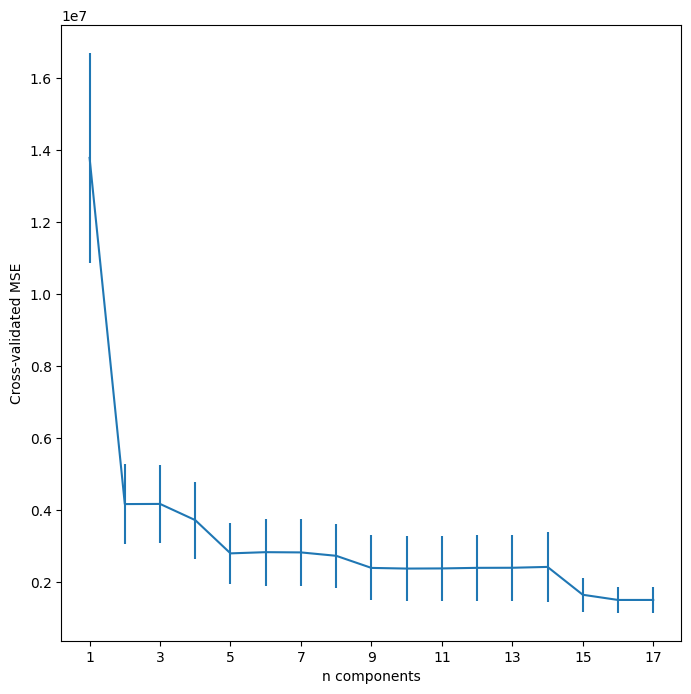

In [241]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, 
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5)) #number of folds
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('n components')
ax.set_xticks(n_comp[::2])


In [242]:
apps_pcr_pipe.fit(train_x, train_y)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('linreg', LinearRegression())])

In [243]:
apps_pcr_preds = apps_pcr_pipe.predict(test_x)
apps_pcr_mse = mean_squared_error(apps_pcr_preds, test_y)
apps_pcr_mse

3510260.81608292

*(f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.*

In [246]:
scaler = StandardScaler()
pls = PLSRegression()
apps_pls_pipe = Pipeline([('scaler', scaler), ('pls', pls)])

In [248]:
param_grid = {'pls__n_components': range(1, 17)}
grid = skm.GridSearchCV(apps_pls_pipe,
                        param_grid,
                        cv=5,
                        scoring='neg_mean_squared_error')
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pls', PLSRegression())]),
             param_grid={'pls__n_components': range(1, 17)},
             scoring='neg_mean_squared_error')

We can see that the MSE is minimised at 13 components. However, a simpler model with 5 components gives almost the same accuracy and will generalise better to the test data.

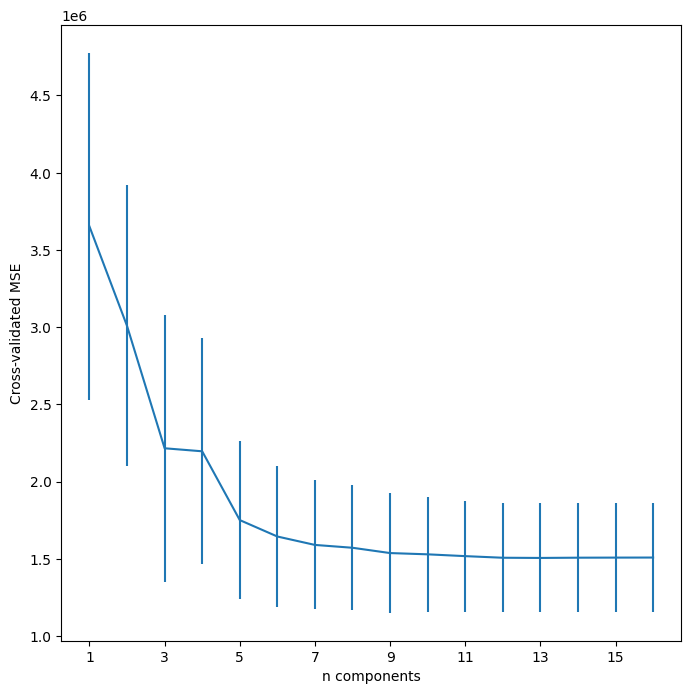

In [250]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
n_comp = param_grid['pls__n_components']
ax.errorbar(n_comp, 
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5)) #number of folds
ax.set_ylabel('Cross-validated MSE')
ax.set_xlabel('n components')
ax.set_xticks(n_comp[::2])


In [258]:
pls = PLSRegression(n_components=5)
apps_pls_pipe = Pipeline([('scaler', scaler), ('pls', pls)])

In [259]:
apps_pls_pipe.fit(train_x, train_y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('pls', PLSRegression(n_components=5))])

In [260]:
apps_pls_pred = apps_pls_pipe.predict(test_x)
apps_pls_mse = mean_squared_error(test_y, apps_pls_pred)
apps_pls_mse

1928696.9820554592

*(g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?*

We can see that OLS, Ridge, Lasso and PLS all give similar mean squared errors. The PCR is notably worse at predicting application

<Axes: title={'center': 'MSE by model'}, xlabel='Model'>

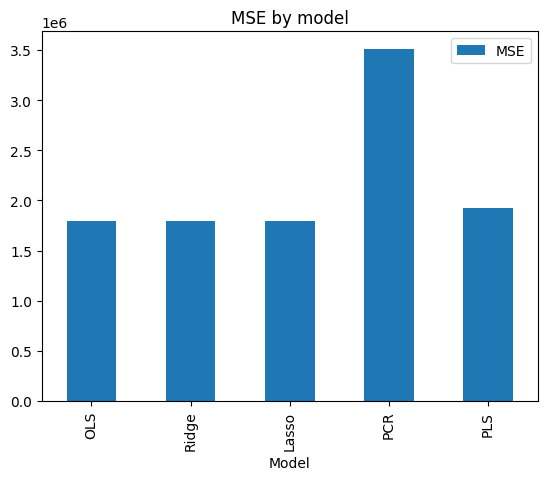

In [268]:
mse_df = pd.DataFrame(data = {
    'Model':['OLS', 'Ridge', 'Lasso', 'PCR', 'PLS'],
    'MSE':[apps_ols_mse, apps_ridge_mse, apps_lasso_mse, apps_pcr_mse, apps_pls_mse]
})
mse_df.set_index('Model').plot(kind='bar', title='MSE by model')

**3.We have seen that as the number of features used in a model increases, the training error will necessarily decrease, but the test error may not. We will now explore this in a simulated data set.**

*(a) Generate a data set with $p = 20$ features, $n = 1000$ observations, and an associated quantitative response vector generated according to the model*

$$
Y = X\beta + \epsilon
$$

*where $\beta$ has some elements that are exactly equal to zero.*